# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>

## Метод главных компонент (Principal Component Analysis, PCA)


Метод главных компонент это статистический метод, который используется для уменьшения размерности данных, сохраняя при этом как можно больше информации.

Основная идея PCA заключается в том, чтобы преобразовать исходные переменные в новый набор некоррелированных переменных, которые называются *главными компонентами*. Главные компоненты создаются так, чтобы первая компонента объясняла наибольшую долю дисперсии исходных данных, вторая — следующую по величине долю и так далее. Сжатое представление данных в виде главных компонент может быть использовано для визуализации многомерных данных, для кластеризации, в качестве входных данных для других методов машинного обучения или для других аналитических целей. Подробнее теорию метода можно посмотреть в <a href="https://miptstats.github.io/courses/ad_fivt/lecture8.pdf">презентации</a> с лекции. Применение PCA в задаче кластеризации можно посмотреть в <a href="https://miptstats.github.io/courses/ad_fivt/clustering.html" target="_blank">следующем ноутбуке</a>.

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.auto import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imageio
from IPython.display import Image

sns.set_theme(style="darkgrid", palette="Set2")

#### Реализация PCA из sklearn

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA">`sklearn.decomposition.PCA`</a>`(n_components=None)`

Самый важный параметр: 
* `n_components` &mdash; размерность сжатого пространства, иными словами количество главных компоненты.

Методы класса:
* `fit(X)` &mdash; обучиться на данных `X`;
* `transform(X_new)` &mdash; вернуть сжатое представление `X_new` для обученной ранее модели;
* `fit_transforn(X)` &mdash; обучиться на данных `X` и вернуть сжатое представление `X`;
* `inverse_transform(Y)` &mdash; восстановить сжатые данные `Y` в исходное пространство.

Атрибуты класса:

* `components_` &mdash; главные компоненты в порядке убывания доли объясненной дисперсии (собственных чисел), размер `(n_components, n_features)`;
* `explained_variance_` &mdash; дисперсия вдоль главных компонент, равны собственным числам, размер `(n_components,)`;
* `explained_variance_ratio_` &mdash; доля дисперсии, объясняемая каждой компонентой, размер `(n_components,)`;
* `mean_` &mdash; среднее по данным, размер `(n_features,)`.


### 1. Простой пример

Вначале рассмотрим самый простой пример: отобразим двумерные данные в одномерное пространство, а затем применим обратное преобразование

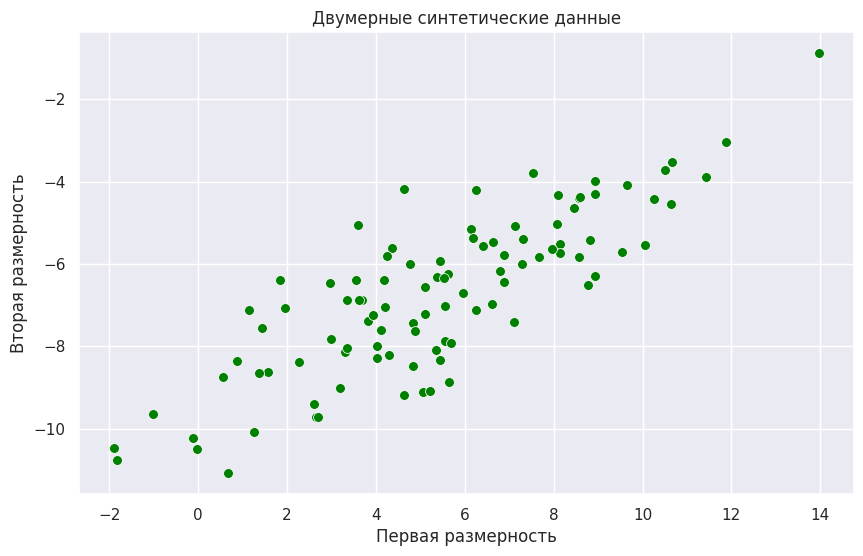

In [2]:
# Сгенерируем 100 точек в двумерном пространстве
n = 100  # Размер выборки
sample = sps.multivariate_normal(mean=[5, -7], cov=[[13, 7], [7, 5]]).rvs(
    n, random_state=42
)

# Визуализируем полученную выборку
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sample[:, 0], y=sample[:, 1], s=50, c="g")

plt.title("Двумерные синтетические данные")
plt.xlabel("Первая размерность")
plt.ylabel("Вторая размерность")
plt.show()

Применим PCA для отображения в одномерное пространство (`n_components=1`)

Направления главных компонент в исходном пространстве (одной компоненты): [[0.87  0.494]]
Среднее по данным: [ 5.396 -6.732] == [ 5.396 -6.732]
Размерность проекции: (100, 1)


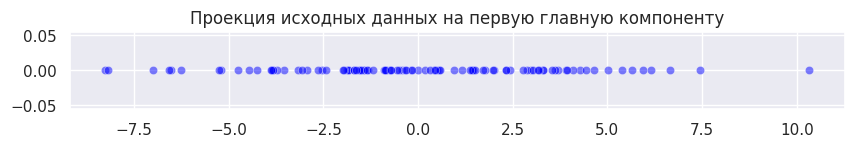

In [3]:
pca = PCA(n_components=1)
# Обучаем и тут же применяем PCA к выборке sample
sample_projection = pca.fit_transform(sample)

print(
    f"Направления главных компонент в исходном пространстве (одной компоненты): {pca.components_.round(3)}"
)
print(f"Среднее по данным: {pca.mean_.round(3)} == {sample.mean(axis=0).round(3)}")
print(f"Размерность проекции: {sample_projection.shape}")

# Визуализируем на числовой прямой проекцию после применения PCA
plt.figure(figsize=(10, 1))
sns.scatterplot(x=sample_projection[:, 0], y=0, c="b", alpha=0.5)

plt.title("Проекция исходных данных на первую главную компоненту")
plt.show()

Теперь применим обратное преобразование и визуализируем вместе с исходными точками

Размерность репроекции в исходное пространство: (100, 2)


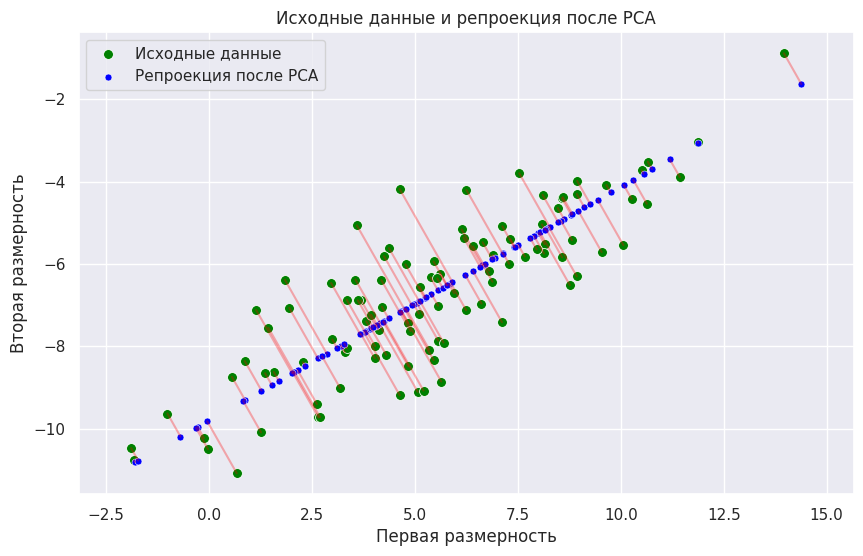

In [4]:
# Применяем обратное преобразование
sample_reprojection = pca.inverse_transform(sample_projection)
print(f"Размерность репроекции в исходное пространство: {sample_reprojection.shape}")

# Визуализируем
plt.figure(figsize=(10, 6))

# Рисуем отрезки, соединяющие исходную точку и ее образ
for point, reproj in zip(sample, sample_reprojection):
    plt.plot([point[0], reproj[0]], [point[1], reproj[1]], c="r", alpha=0.3)

# Рисуем исходные точки
sns.scatterplot(x=sample[:, 0], y=sample[:, 1], s=50, c="g", label="Исходные данные")
# Рисуем восстановленные точки
sns.scatterplot(
    x=sample_reprojection[:, 0],
    y=sample_reprojection[:, 1],
    s=25,
    c="b",
    label="Репроекция после PCA",
)

plt.axis(
    "equal"
)  # Включаем одинаковый масштаб по обоим осям, чтобы увидеть прямой угол
plt.title("Исходные данные и репроекция после PCA")
plt.xlabel("Первая размерность")
plt.ylabel("Вторая размерность")
plt.show()

Можно заметить несколько интересных моментов:
- Восстановленные данные лежат на одной прямой. Это объясняется линейностью обратного преобразования, а прямые (в частности любые одномерные данные) всегда переходят в прямые при линейном отображении.
- Отрезки соединяющие исходные точки и их восстановленные образы перпендикулярны прямой с образами. Так происходит, потому что PCA стремится максимизировать дисперсию вдоль первой главной компоненты, а значит минимизировать дисперсию (расстояние между точкой и образом) в нормальном направлении к этой прямой.

### 2. PCA для сжатия датасетов изображений лиц

Изображения можно рассматривать как большие многомерные вектора. Попробуем применить к ним PCA.


Для начала загрузим <a download="train_faces.npy" href="./train_faces.npy">датасет</a> фотографий человеческих лиц. В нем 280 изображений, каждое размера $32 \times 32$ пикселя, то есть размерность одного вектора 1024.

Размерность faces: (280, 1024)


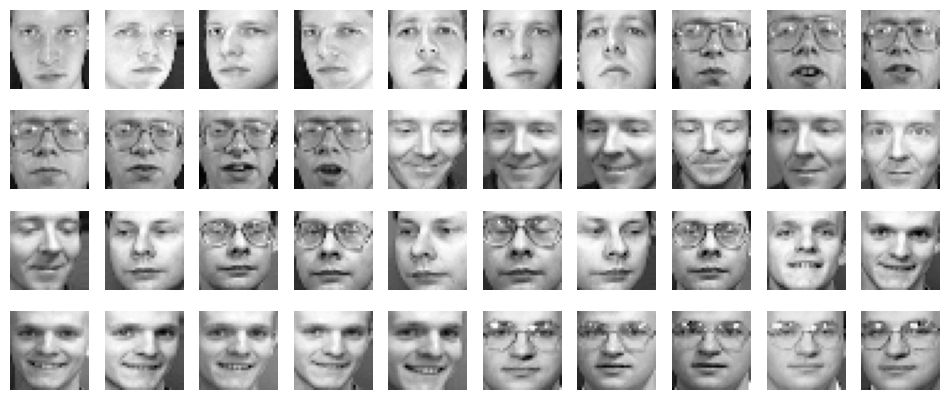

In [5]:
faces = np.loadtxt("data/train_faces.npy")
print(f"Размерность faces: {faces.shape}")

# Визуализируем несколько примеров из датасета
plt.figure(figsize=(12, 5))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(faces[i].reshape((32, 32)), cmap="gray")
    plt.axis("off")

Сделаем проекцию из исходного 1024-мерного пространства в 50-мерное с помощью PCA. Таким образом все изображения разложатся в сумму среднего и линейной комбинации из 50-ти изображений, являющихся первыми 50-тью главными компонентами.

In [6]:
pca = PCA(n_components=50)
faces_projection = pca.fit_transform(faces)
print(f"Размерность проекции: {faces_projection.shape}")

Размерность проекции: (280, 50)


Визуализируем главные компоненты (по сути базисы, на которые разложилось каждое изображение):

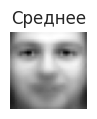

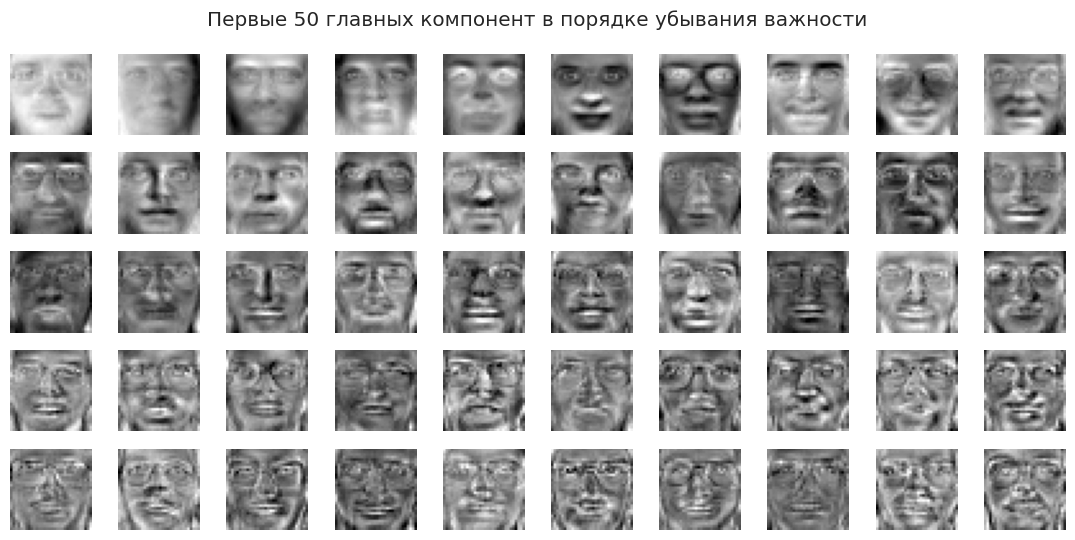

In [7]:
def rescale_image(image):
    """
    Линейно переводит минимальное значение массива в 0, а максимальное в 1

    :param image: массив для преобразования
    """
    return (image - image.min()) / (image.max() - image.min())


def visualize_main_components(pca, num_components=50, image_shape=(32, 32)):
    """
    Визуализирует первые главные компоненты при PCA проекции

    :param pca: обученный PCA
    :param num_components: сколько компонент визуализировать
    :param image_shape: размерность изображения, например,
                        (32, 32) для ч/б или (64, 64, 3) для цветного изображения
    """
    cmap = "gray" if image_shape[-1] != 3 else None
    n_cols = 10
    n_rows = (num_components + n_cols - 1) // n_cols

    plt.figure(figsize=(1, 1))
    plt.imshow(rescale_image(pca.mean_.reshape(image_shape)), cmap=cmap)
    plt.title("Среднее")
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(n_cols * 1.1, n_rows * 1.1))
    plt.suptitle(
        f"Первые {num_components} главных компонент в порядке убывания важности"
    )
    for i in range(num_components):
        plt.subplot(n_rows, n_cols, i + 1)
        # Так как значения каждого пикселя изображения должны быть на отрезке [0, 1],
        # а главные компоненты могут не удовлетворять этому условию, отнормируем их
        plt.imshow(rescale_image(pca.components_[i].reshape(image_shape)), cmap=cmap)
        plt.axis("off")

    plt.tight_layout()


visualize_main_components(pca, num_components=50)

Как видно на всех главных компонентах прослеживаются очертания лиц. Причем, если первые компоненты больше размытые с нечеткими границами, то в последних наоборот выделяются различные детали. 

Теперь для нескольких примеров изображений посмотрим с каким весом в них входит каждая главная компонента. Ниже 
* в первой колонке изображено исходное лицо, 
* во второй его приближение (проекция на первые 10 главных компонент),
* в третьей колонке среднее лицо, 
* в следующих 10 колонках первые 10 главных компонент, над которыми указаны коэффициенты, с которыми они входят в приближаемое лицо.

Стоит отметить, что все компоненты нормированны, однако при отрисовке они растягиваются до диаппазона $[0, 255]$. Поэтому коэффициенты относятся не к изображениям компонент, а к самим нормированным компонентам.

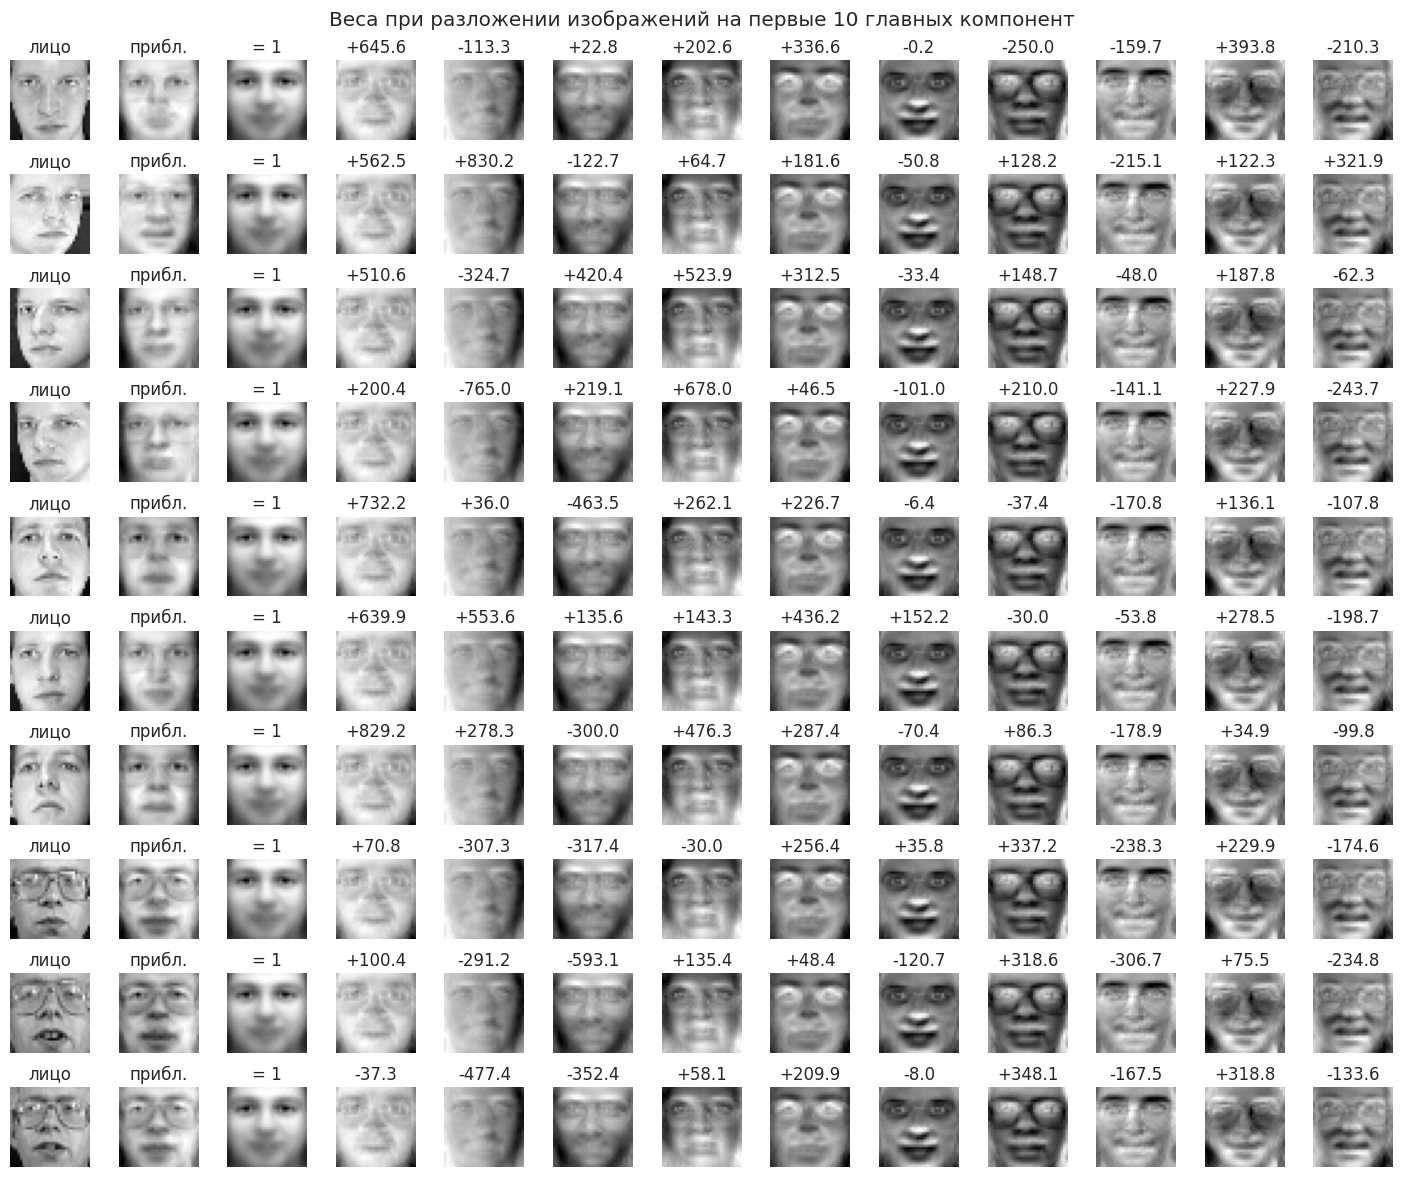

In [8]:
def visualize_projection_images(
    images, n_components, num_images=5, image_shape=(32, 32)
):
    """
    Визуализирует проекции изображений на первые несколько главных компонент

    :param images: датасет изображений, на котором обучается PCA
    :param n_components: количество главных компонент
    :param num_images: количество первых изображения датасета для отображения
    :param image_shape: размерность изображения
    """

    pca = PCA(n_components=n_components)
    projection = pca.fit_transform(images)
    reprojection = pca.inverse_transform(projection)

    cmap = "gray" if image_shape[-1] != 3 else None
    num_columns = 3 + n_components

    plt.figure(figsize=(1.1 * num_columns, 1.2 * num_images))
    plt.suptitle(
        f"Веса при разложении изображений на первые {n_components} главных компонент"
    )

    for image_index in range(num_images):
        plt.subplot(num_images, num_columns, image_index * num_columns + 1)
        plt.imshow(images[image_index].reshape(image_shape), cmap=cmap)
        plt.title("лицо")
        plt.axis("off")

        plt.subplot(num_images, num_columns, image_index * num_columns + 2)
        plt.imshow(
            np.clip(reprojection[image_index].reshape(image_shape) / 255, 0, 1),
            cmap=cmap,
        )
        plt.title("прибл.")
        plt.axis("off")

        plt.subplot(num_images, num_columns, image_index * num_columns + 3)
        plt.imshow(np.clip(pca.mean_.reshape(image_shape) / 255, 0, 1), cmap=cmap)
        plt.title("= 1")
        plt.axis("off")

        for component_idx in range(n_components):
            plt.subplot(
                num_images, num_columns, image_index * num_columns + 4 + component_idx
            )
            plt.imshow(
                rescale_image(pca.components_[component_idx].reshape(image_shape)),
                cmap=cmap,
            )

            coef = projection[image_index, component_idx]
            sign = "+" if coef >= 0 else ""
            plt.title(f"{sign}{coef:.1f}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


visualize_projection_images(faces, n_components=10, num_images=10, image_shape=(32, 32))


Проведем эксперимент: переберем несколько значений `n_components` (количество главных компонент), для каждого обучим PCA, сделаем последовательно прямое и обратное преобразования, а затем визуально сравним полученные изображения с исходным.

  0%|          | 0/9 [00:00<?, ?it/s]

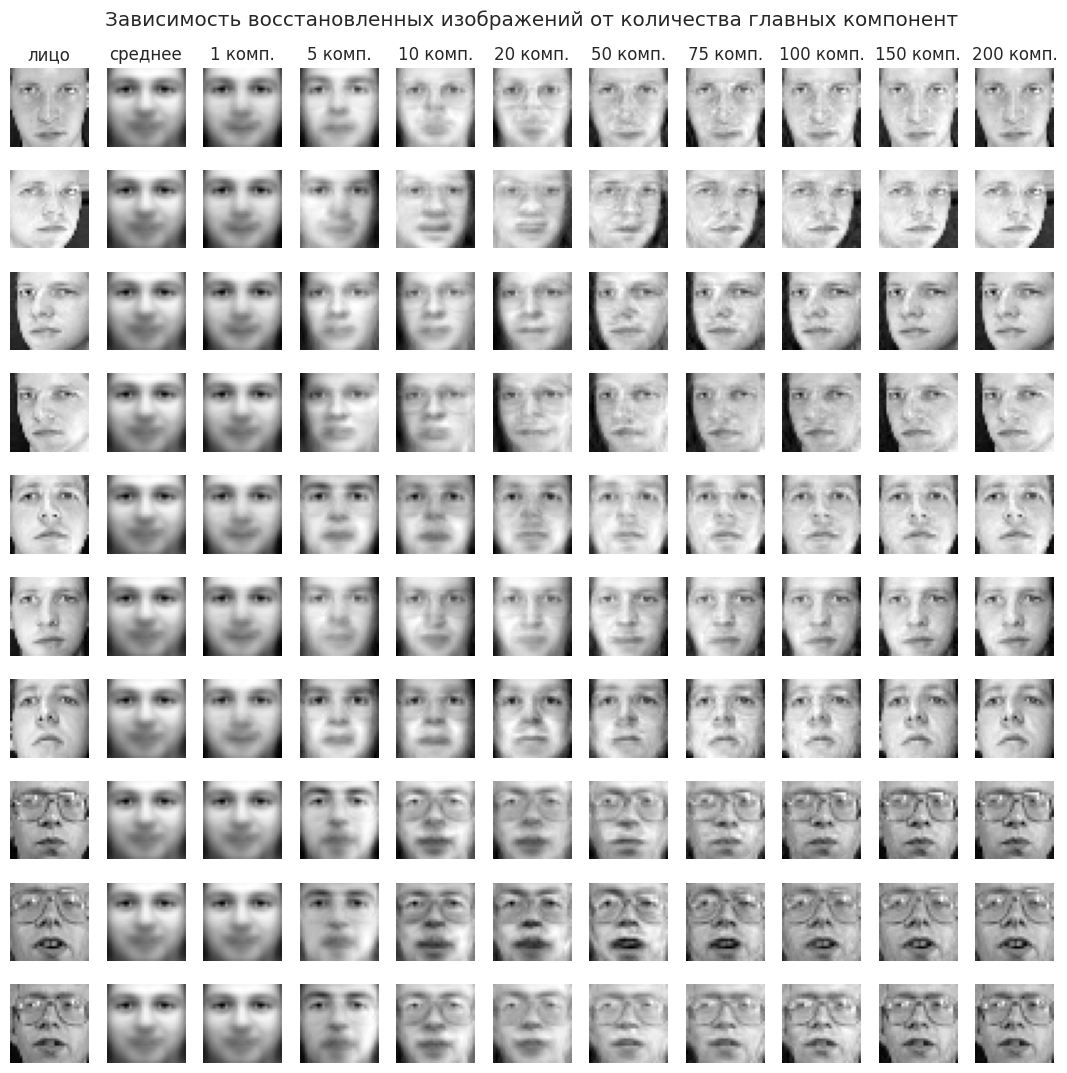

In [9]:
def visualize_decompress_images(
    images, n_components_grid, num_images=5, image_shape=(32, 32)
):
    """
    Визуализирует восстановленные изображения для различного количества главных компонент

    :param images: датасет изображений, на котором обучается PCA
    :param n_components_grid: сетка количества главных компонент
    :param num_images: количество первых изображения датасета для отображения
    :param image_shape: размерность изображения
    """
    reprojections = {}

    for n_components in tqdm(n_components_grid):
        pca = PCA(n_components=n_components)
        projection = pca.fit_transform(images)
        reprojections[n_components] = pca.inverse_transform(projection)

    num_columns = 2 + len(n_components_grid)

    cmap = "gray" if image_shape[-1] != 3 else None
    plt.figure(figsize=(1.2 * len(n_components_grid), 1.1 * num_images))
    plt.suptitle(
        "Зависимость восстановленных изображений от количества главных компонент"
    )

    for image_index in range(num_images):
        plt.subplot(num_images, num_columns, image_index * num_columns + 1)
        plt.imshow(images[image_index].reshape(image_shape), cmap=cmap)
        if image_index == 0:
            plt.title("лицо")
        plt.axis("off")

        plt.subplot(num_images, num_columns, image_index * num_columns + 2)
        plt.imshow(np.clip(pca.mean_.reshape(image_shape) / 255, 0, 1), cmap=cmap)
        if image_index == 0:
            plt.title("среднее")
        plt.axis("off")

        for col, n_components in enumerate(n_components_grid):
            plt.subplot(num_images, num_columns, image_index * num_columns + 3 + col)
            reproj = reprojections[n_components][image_index]
            plt.imshow(np.clip(reproj.reshape(image_shape) / 255, 0, 1), cmap=cmap)
            if image_index == 0:
                plt.title(f"{n_components} комп.")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

    return reprojections


faces_reprojections = visualize_decompress_images(
    faces,
    n_components_grid=[1, 5, 10, 20, 50, 75, 100, 150, 200],
    num_images=10,
    image_shape=(32, 32),
)

### 3. PCA для сжатия датасетов изображений котиков


Как видно уже для 150 главных компонент разница между оригиналом и восстановленным изображением визуально почти незаметна.

Однако черно-белые маленькие изображения уж слишком игрушечный пример. Посмотрим на более интересный датасет котиков. В нем более 15000 цветных фотографий размером $64 \times 64$, то есть им соответствует вектор размера $3 \cdot 64 \cdot 64 = 12288$.

Загрузим <a download="cats.zip" href="./cats.zip">датасет</a> и посмотрим несколько примеров.

Размерность cats: (15747, 12288)


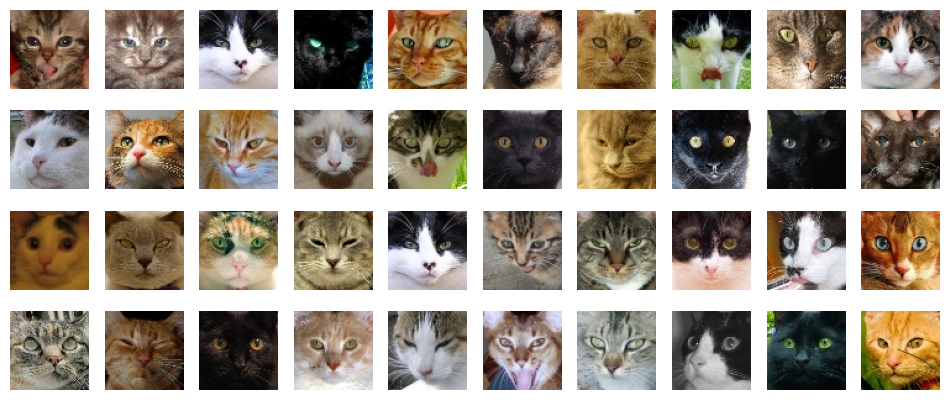

In [10]:
cats_path = "data/cats"
cats = []

for filename in os.listdir(cats_path):
    cats.append(plt.imread(os.path.join(cats_path, filename)))

cats = np.stack(cats).reshape(-1, 64 * 64 * 3)
print(f"Размерность cats: {cats.shape}")

# Визуализируем примеры
plt.figure(figsize=(12, 5))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(cats[i].reshape(64, 64, 3))
    plt.axis("off")

Также как и ранее посмотрим на изображения, соответсвующие первым 70 главным компонентам

Размерность проекции: (15747, 100)


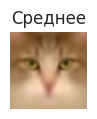

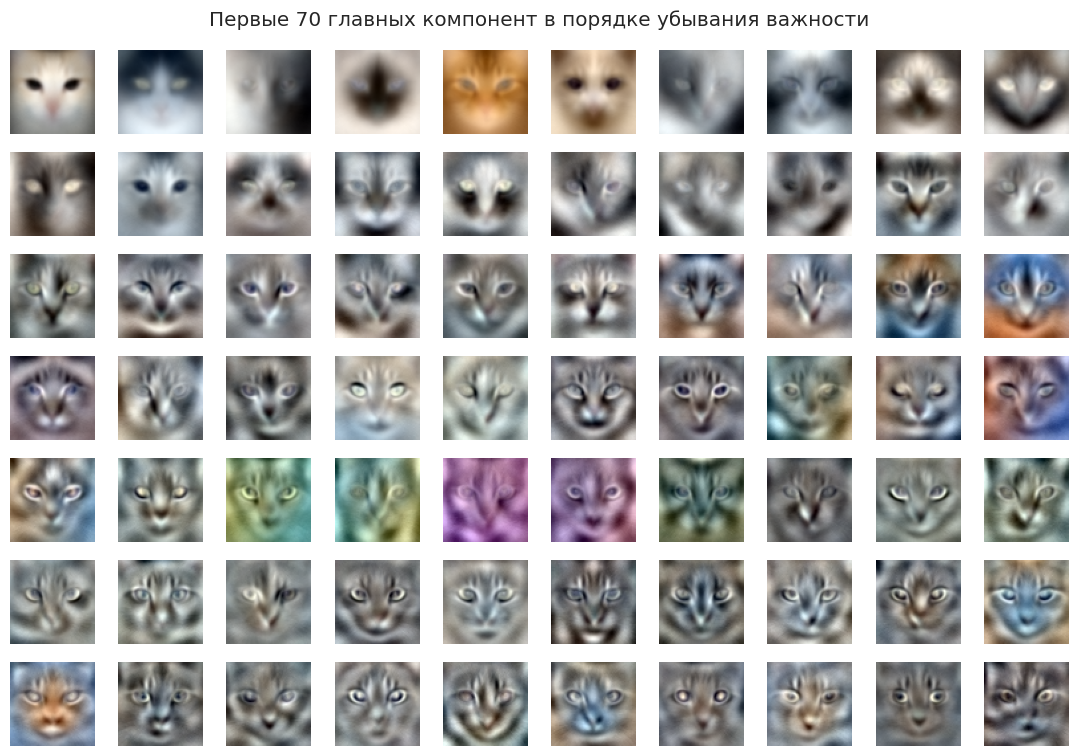

In [11]:
pca = PCA(n_components=100)
cats_projection = pca.fit_transform(cats.astype(np.float32))
print(f"Размерность проекции: {cats_projection.shape}")

visualize_main_components(pca, num_components=70, image_shape=(64, 64, 3))

Как и для лиц видим, что первые компоненты получаются размытыми, с общими очертаниями котов, а затем идут уже более детальные картинки.

Теперь посмотрим с какими коэффициентами входят первые 10 главных компонент в изображение

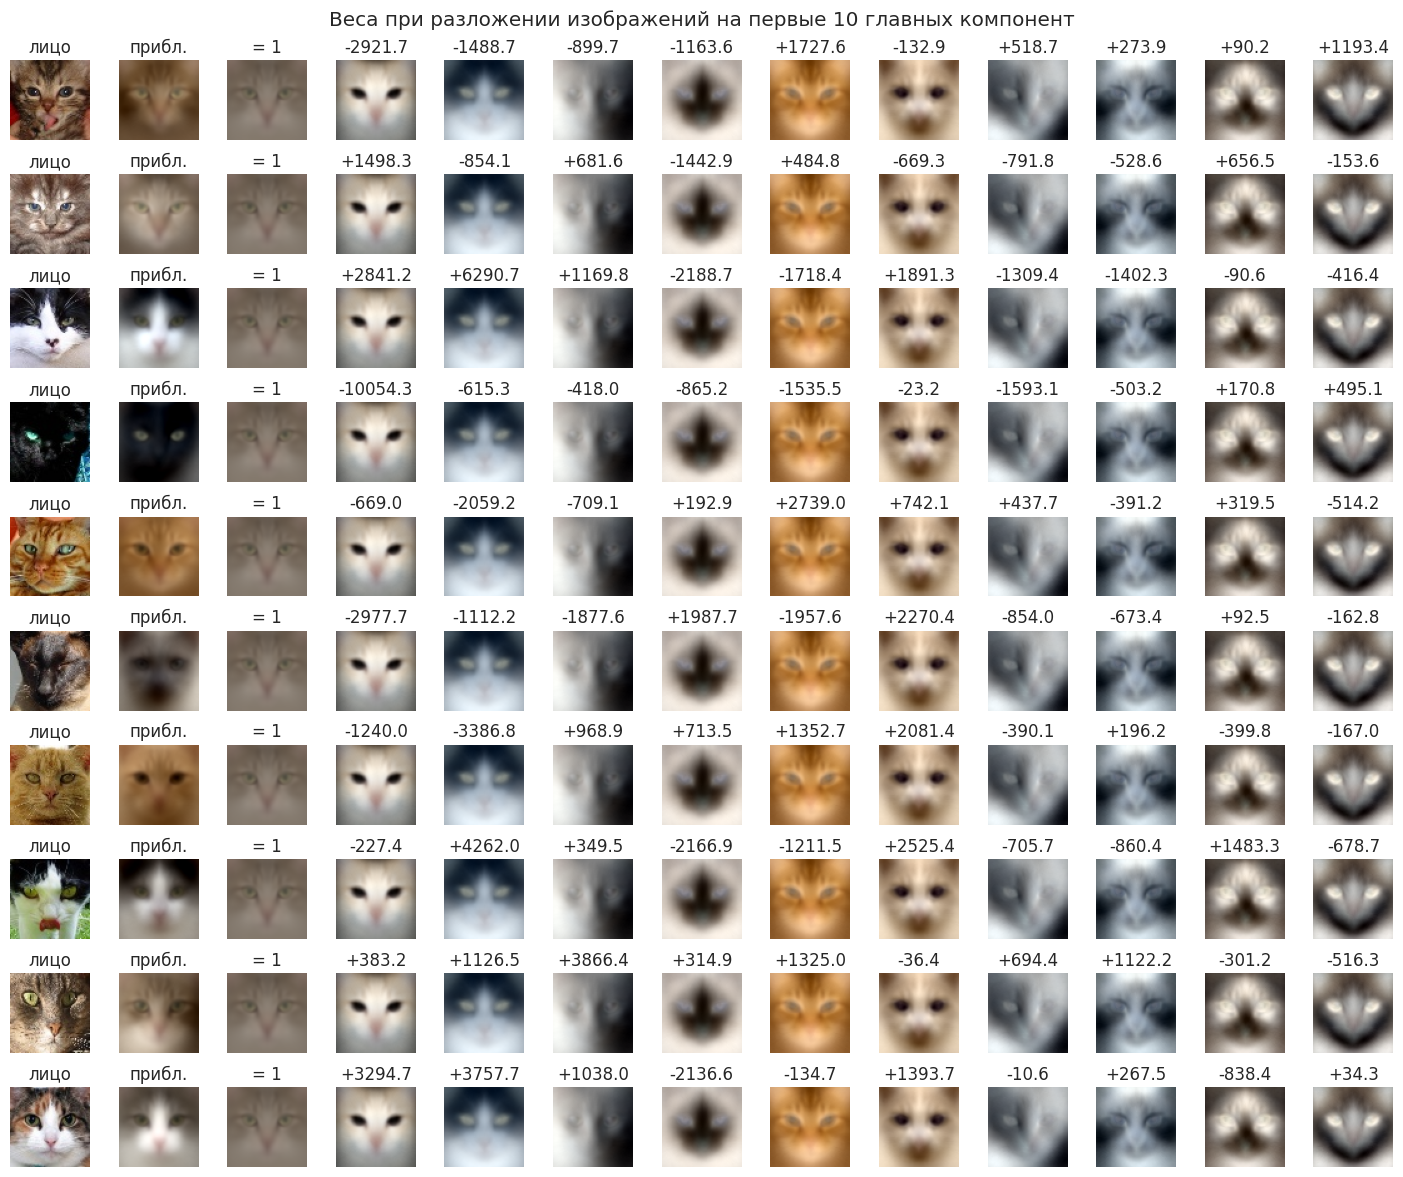

In [12]:
visualize_projection_images(
    cats, n_components=10, num_images=10, image_shape=(64, 64, 3)
)

Также посмотрим на качество восстановленных изображений в зависимости от числа главных компонент.

  0%|          | 0/9 [00:00<?, ?it/s]

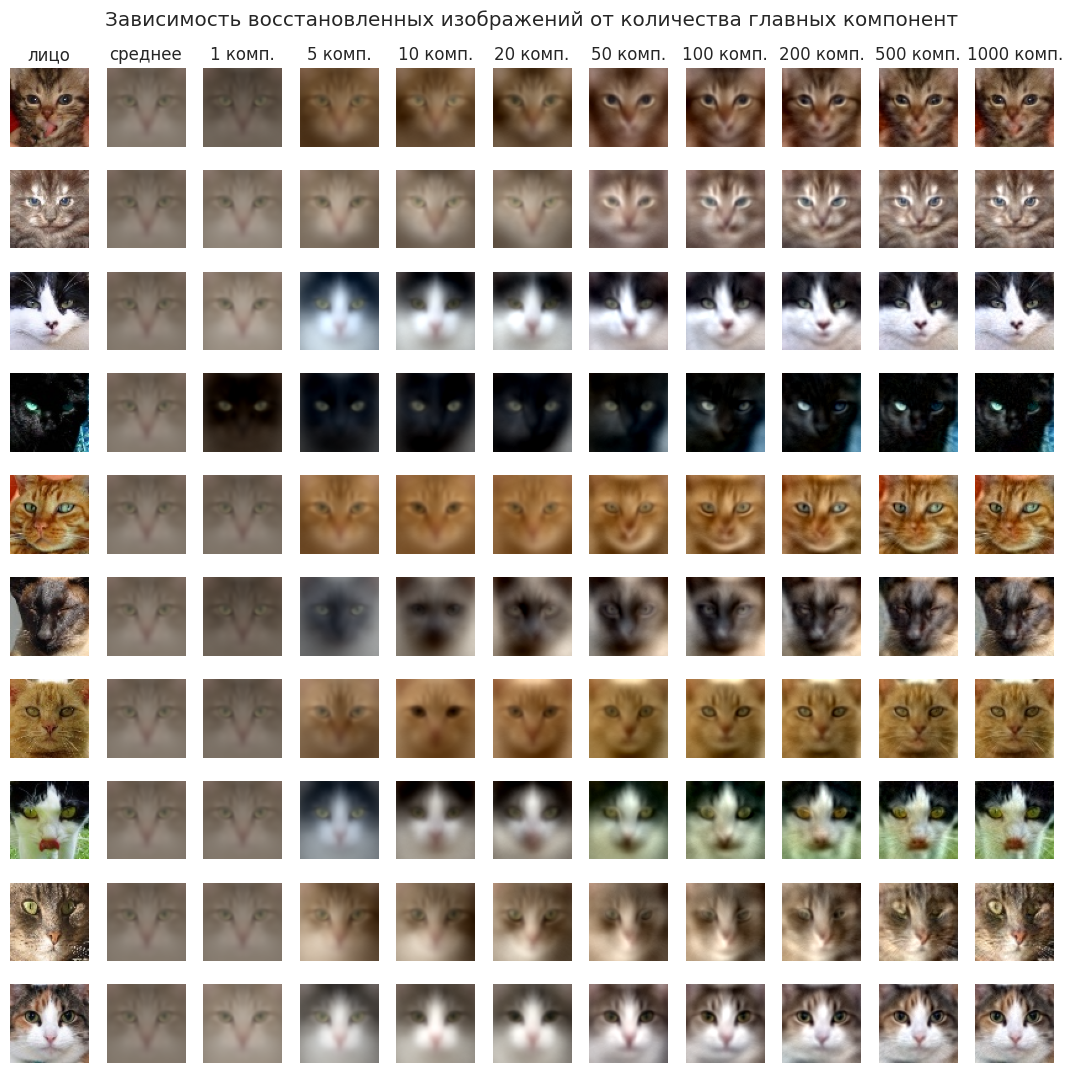

In [13]:
cats_reprojections = visualize_decompress_images(
    cats,
    n_components_grid=[1, 5, 10, 20, 50, 100, 200, 500, 1000],
    num_images=10,
    image_shape=(64, 64, 3),
)

Видим, что уже для 500 главных компонент восстановленные изображения почти не отличаются от оригинальных.

Оценим во сколько раз можно уменьшить размер данного датасета при сжатии в 500-мерное пространство.

Пусть всего $n$ изображений размерности $D$ и делается проекция на $d$ главных компонент, тогда:
- каждое изображение представляется вектором размерности $d$ из `float32`, всего изображений $n$; получаем $4dn$ байт;
- $d$ главных компонент размерности $D$ состоят также из `float32`; получаем $4dD$ байт;
- суммарно выходит $4d \left(D + n\right)$ байт, в то время как исходный датасет занимает $nD$ байт.

Подставив числа для нашего датасета: $n=15747, d=500, D=64 \cdot 64 \cdot 3$ получаем, что исходные картинки весят $185$ МБ, а сжатые картинки $53$ МБ, то есть размер уменьшился в $3.5$ раза.

### 4. Бонус: гифка

Сделаем гифку изменения восстановленного изображения в зависимости от числа главных компонент. Также вместо центрального изображения вставим визуализацию соответствующей главной компоненты

In [14]:
pca = PCA(n_components=1000)
cats_projection = pca.fit_transform(cats.astype(np.float32))

cnt_cats = 9
gif_images = []

image_size = 64
border_size = 2

for num_components in range(1, 1000):
    # Делаем проекцию на первые num_components главных компонент
    projection = (cats[:cnt_cats] - pca.mean_) @ pca.components_[:num_components].T
    # Восстанавливаем спроецированные изображения
    reprojection = projection @ pca.components_[:num_components] + pca.mean_

    # Решейпим вектора в матрицы пикселей
    compressed_images = (
        reprojection.reshape(-1, image_size, image_size, 3)
        .clip(0, 255)
        .astype(np.uint8)
    )

    # Подготавливаем главную компоненту
    pca_component = (
        rescale_image(pca.components_[num_components].reshape(64, 64, 3)) * 255
    ).astype(np.uint8)

    # Собираем коллаж 3х3: в центре текущая num_components-ая главная компонента,
    # по бокам восстановленные изображения
    collage = np.zeros(
        (image_size * 3 + border_size * 2, image_size * 3 + border_size * 2, 3),
        dtype=np.uint8,
    )
    for i, image in enumerate(compressed_images):
        row_begin = (i % 3) * (border_size + image_size)
        col_begin = (i // 3) * (border_size + image_size)

        # Если i == 4, то это центральное изображение, заменяем его на главную компоненту
        if i == 4:
            image = pca_component
        collage[
            row_begin : row_begin + image_size, col_begin : col_begin + image_size
        ] = image

    # Добавляем полученный коллаж в общий массив, перед этим растянув его в два раза
    gif_images.append(
        cv2.resize(
            collage,
            dsize=(collage.shape[0] * 2, collage.shape[0] * 2),
            interpolation=cv2.INTER_CUBIC,
        )
    )

In [15]:
# Для ускорения гифки на большом количестве компонент будем выкидывать часть кадров
frames = gif_images[:50] + gif_images[50:200:3] + gif_images[200::10]
imageio.mimsave("transformation.gif", frames * 5, format="GIF")

Image(url="transformation.gif")